# A hand-made chi2 fit (incomplete - edit where indicated to make it work)

You can view these sheets on github, but to modify them, you'll need to a version of jupyter. How to install it is explained here: http://jupyter.readthedocs.io/en/latest/install.html.
If you want to use the functions defined below to generate your own distributions, you need to compile them first. Easiest done by clicking (once have opened this as jupyter notebook): Kernel -> Restart & Run All. (Alternatively, you can use the >| button to click your way through, but you need to start from the beginning to have access to all functions defined on this sheet). Have fun!

Let's generate a few distributions and calculate the mean, mode, median for each.
Start by importing the relevant libraries

In [1]:
from math import *
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Let's generate a distribution we want to fit. We take an exponential

In [2]:
def generateExpo(tau=1, Nevents=10000, randomSeed=-1):
    if randomSeed >=0: np.random.seed(randomSeed)
    expoSample = np.random.exponential(scale = tau, size=Nevents)
    return expoSample

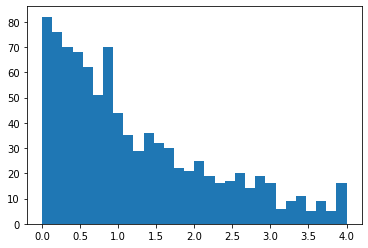

In [3]:
Nevents=1000
Nbins=30
histoRange=(0,4)
expoSample = generateExpo(1.5, Nevents)
timeHisto=plt.hist(expoSample, Nbins, histoRange) # make histogram
plt.show()

Define the theoretical distribution

In [4]:
def expo(t, tau):
    return np.exp(-t/tau)/tau
def expoIntegral(t, tau, integRange=(0.0, -999.9)):
    lower=np.exp(-integRange[0]/tau)
    upper=0
    if integRange[1] > -999.8: upper = np.exp(-integRange[1]/tau)
    return lower-upper
def expoNorm(t, tau, integRange):
    return expo(t, tau)/expoIntegral(t, tau, integRange)

We could continue with these  functions, but it turns out to be more convenient to cast them into a class. The reason is that it allows us to write routines like draw(), below, that will plot any function, no matter how many parameters, as long as the class has the __call__ and the mini, maxi routines defined.

In [5]:
class expoClass:
    def __init__(self, tau=1.5, funcRange=(0.0, 100)):
        self._tau=tau
        self._range=funcRange
    def setTau(self,tau):
        self._tau=tau
    def interval(self):
        return self._range
    def mini(self):
        return self._range[0]
    def maxi(self):
        return self._range[1]
    def range(self):
        return self._range
    def __call__(self, t):
        #return expo(t, self._tau)
        return expoNorm(t, self._tau, self._range)

...let's create an instance of our expoClass:

In [6]:
timeFct = expoClass(1.6, (0, 4))  
# timeFct is now defined such that timeFct(t) will call whetever is in 
# the __call__ routine of expoClass, currently return expo(t, self._tau)

... and draw it:

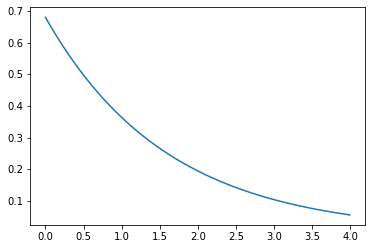

In [7]:
def draw(somethingLikeExpoClass, scale=1, numPoints=1000):
    mini=somethingLikeExpoClass.mini()
    maxi=somethingLikeExpoClass.maxi()
    tArray=np.arange(mini, maxi, (maxi-mini)/numPoints)
    plt.plot(tArray,scale*somethingLikeExpoClass(tArray))

draw(timeFct)

Now we define a function that calculates the chi2 between the histogram and the theoretical distribution
# edit the function below to calculate the chi-squared

In [13]:
def chi2(h, functionClass):
    ## Note that the theoretical function is normalised to one. 
    ## To get the expected number of events, we 
    ## will need the total number of events, and the binwidth.
    N=fsum(h[0])
    chi2sum=0
    for Nbin, bin_low, bin_up in zip(h[0], h[1], h[1][1:]):
        binCentre=0.5*(bin_low + bin_up)
        binWidth= bin_up - bin_low
        theory=N*binWidth*functionClass(binCentre) 
        measured=Nbin
        error_squared= theory
        chi2sum += ((measured - theory)**2)/error_squared    
    return chi2sum      
        

Now we have all the ingredients to calculate the chi2. Let's do it:

In [14]:
chi2(timeHisto,timeFct)

36.03227531992465

Let's try different values of tau

In [15]:
timeFct.setTau(1)
print(chi2(timeHisto, timeFct))
timeFct.setTau(1.5)
print(chi2(timeHisto, timeFct))
timeFct.setTau(2)
print(chi2(timeHisto, timeFct))

200.17956353313718
38.263620816648896
50.885966990335085


That was informative, as it suggests the fit value is somewhere between 1 and 2. But we need to make this a bit more systematic:

min at  1.6129999999999656  +  0.08524999999999072  -  0.0772499999999916 
with chi2 at min of  36.00634297780771


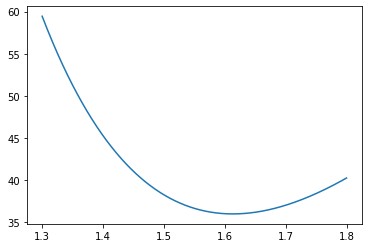

In [16]:
class Chi2Scan:
    def __init__(self, h, fcn):
        self._h = h
        self._fcn =fcn
        self._tArray=[]
        self._chi2Array=[]
        self._minChi2=-999.9
        self._taumin=-999.9
        self._error_low=-999.9
        self._error_high=-999.9
    def Chi2_of_tau(self, tau):
        self._fcn.setTau(tau)
        return chi2(self._h, self._fcn)

    def scan(self, interval, numsteps):
        stepsize = (interval[1]-interval[0])/numsteps
        self._tArray=np.arange(interval[0], interval[1], stepsize)
        self._chi2Array=self.Chi2_of_tau(self._tArray)
        
    def plot(self, interval=(0,0), numsteps=0):
        if numsteps > 0: # only then re-do scan
            self.scan(interval, numsteps)
        plt.plot(self._tArray,self._chi2Array)
        plt.show
        
    def findMin(self, interval=(0,0), numsteps=0):
        if numsteps > 0: # only then re-do scan
            self.scan(interval, numsteps)
        self._minChi2=self._chi2Array[0]
        self._taumin=self._tArray[0]
        for time, chi2 in zip(self._tArray, self._chi2Array):
            if chi2 < self._minChi2:
                self._minChi2=chi2
                self._taumin=time
        return self._taumin, self._minChi2
    
    def findErrors(self, interval=(0,0), numsteps=0):
        if numsteps > 0: # only then re-do scan
            self.scan(interval, numsteps)
            findMin()
        shiftedChi2 = self._chi2Array - self._minChi2 - 1
        prevChi2=shiftedChi2[0]
        prevTime=self._tArray[0]
        for time, chi2 in zip(self._tArray, shiftedChi2):
            if prevChi2*chi2 < 0:
                if time < self._taumin:
                    self._error_low = -(0.5*(time + prevTime)-self._taumin)
                if time > self._taumin:
                    self._error_high = 0.5*(time + prevTime)-self._taumin
            prevChi2=chi2
            prevTime=time

        return self._error_low, self._error_high

TimeChi2Scan=Chi2Scan(timeHisto, timeFct)
TimeChi2Scan.scan((1.3,1.8), 1000)   ## <<<<<<<< this scan scans through 1000 points - check if this is enough.
taumin, chi2min = TimeChi2Scan.findMin()
err_lo, err_hi = TimeChi2Scan.findErrors()
TimeChi2Scan.plot()

print("min at ", taumin, " + ", err_hi, " - ", err_lo, "\nwith chi2 at min of ", chi2min)



Let's write a function that can draw the data with the fit superimposed to see if it makes any sense:

In [17]:
def drawHistoWithFit(histo, fit):
    fig, ax = plt.subplots()
    #plt.plot(timeHisto[1][0:-1], timeHisto[0][0:], drawstyle="steps-pre")#, align='edge')
    error=np.sqrt(timeHisto[0])
    #plt.bar([0,1,2, 9], [9, 10, 11, 90], align='edge')
    ax.errorbar(timeHisto[1][0:-1], timeHisto[0][0:],
       yerr=error,fmt="r+")
    N=fsum(timeHisto[0])
    binwidth=timeHisto[1][1]-timeHisto[1][0]
    draw(timeFct, scale=N*binwidth)
    plt.show()

and use it - down't forget to set tau to the fit result:

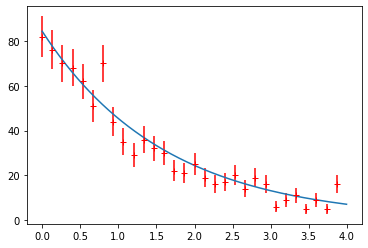

In [18]:
timeFct.setTau(taumin)
drawHistoWithFit(timeHisto, timeFct)

pull study:

In [19]:
def pullStudy(func=timeFct, numEvents=1000, numExperiments=100
              , trueTau=1.5, scanrange=(0,0), numTimeBins=50):
    pull=[]
    pullSum=0.0
    pullSumSq=0.0
    for counter in range(numExperiments):
        simulatedData = generateExpo(trueTau, numEvents)
        histo=plt.hist(simulatedData, numTimeBins, timeFct.range()) # make histogram
        scanner=Chi2Scan(histo, func)
        
        localScanRange=scanrange
        if(scanrange[0] >= scanrange[1]): # if scanrage not set, make one up
            scanmin = trueTau - 8*trueTau/sqrt(numEvents)
            scanmax = trueTau + 8*trueTau/sqrt(numEvents)
            if trueTau - scanmin < 1: scanmin = trueTau-1
            if scanmax - trueTau < 1: scanmax = trueTau+1
            localScanRange=(scanmin, scanmax)
        
        scanner.scan(localScanRange, 1000)
        taumin, chi2min = scanner.findMin()
        err_lo, err_hi = scanner.findErrors()
    # note: I'll take the average error, but taking upper and lower into account
    # seperately, depending on whether your fit is above or below the true value,
    # is more accurate - something you might want to implement.
        err = 0.5*(err_lo + err_hi)
        thisPull = (taumin-trueTau)/err
        pull.append(thisPull)
        pullSum += thisPull
        pullSumSq += thisPull**2
        
    mean=pullSum/numExperiments
    var=pullSumSq/numExperiments - mean*mean
    sigma=np.sqrt(var)
    sigma_on_mean=sigma/sqrt(numExperiments)
    sigma_on_sigma=sigma/sqrt(2*numExperiments)
    print("mean pull (should be 0)", mean, " +- ", sigma_on_mean)
    print("sigma pull (should be 1)", sigma, " +- ", sigma_on_sigma)
    plt.clf()
    plt.hist(pull, 20, (-5, 5))
    plt.show()

mean pull (should be 0) 1.1159190208335432  +-  0.0888771402379812
sigma pull (should be 1) 0.888771402379812  +-  0.06284562855474427


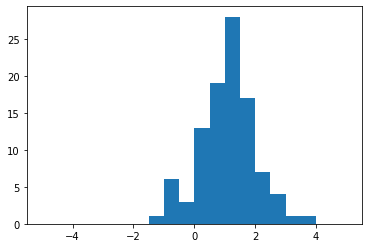

In [22]:
pullStudy(timeFct, numEvents=1000, numExperiments=100
          , trueTau=1.5, scanrange=(0.5, 3), numTimeBins=100) 
# why might you get a bias in this fit? 

# With the default settings, you will get a bias in the fit. 
# Why? How can you reduce it?

The Bias is due to the smaller number of events in the bins, to fix this we can increase the number of events or reduce the number of bins 

mean pull (should be 0) 0.27602923976518856  +-  0.09550029663889763
sigma pull (should be 1) 0.9550029663889763  +-  0.06752890735869137


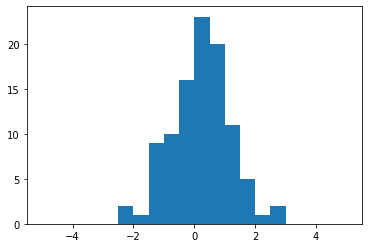

In [28]:
pullStudy(timeFct, numEvents=10000, numExperiments=100, trueTau=1.5, scanrange=(0.5,3), numTimeBins=60)